# Example Notebook For VQE Code
This notebook runs VQE using qiskit aer simulator primitives.  
It automatically reduces the number of qubits required for problem hamiltonian
using `tapering` method.  
It removes some less important components in hamiltonian to make more symmetry and reduce the hamiltonian into `6 qubit hamiltonian`.  
Also aultomatically group the hamiltonian for shot cost effectiveness.  
Lastly, `Reference State Error Mitigation (REM)` is used for improving result.

### Importing Necessary Packages
It uses `qiskit`, `qiskit_nature` and `qiskit_aer` packages for quantum simulation

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

from qiskit import Aer, QuantumCircuit, transpile, pulse
from qiskit_aer.primitives import Sampler
from qiskit.utils import algorithm_globals
from qiskit.providers.fake_provider import *
import qiskit_aer.noise as noise
from qiskit.circuit.library import *

The file `Qubit_taper.py` includes the core functions for our team's submission. \
If the `Qubit_taper.py` file is not in the same directory, path should be appended.  

```python
import sys
sys.path.append('path/to/directory')
import Qubit_taper as Q
```

In [2]:
import Qubit_taper as Q

In [3]:
path_hamiltonian = 'hamiltonian/OHhamiltonian.txt'
path_noise_model = {
  'cairo': 'noise_model/fakecairo.pkl',
  'montreal': 'noise_model/fakemontreal.pkl',
  'kolkata': 'noise_model/fakekolkata.pkl'
}
path_seeds = 'algorithm_seeds/requiredseeds.txt'
dir_qasm = 'qasm'

### Extracting Hamiltonian
We can get problem hamiltonian using pyscf or simply extract from `OHhamiltonian.txt` file.

In [4]:
ultra_simplified_ala_string = """
O 0.0 0.0 0.0
H 0.45 -0.1525 -0.8454
"""
driver = PySCFDriver(
    atom = ultra_simplified_ala_string.strip(),
    basis='sto3g',
    charge=1,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)
problem = driver.run()
fermionic_op = problem.hamiltonian.second_q_op()
mapper = JordanWignerMapper()
hamiltonian = mapper.map(fermionic_op)

/home/dhkim/anaconda3/envs/qiskit/lib/python3.11/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


In [5]:
try:
    with open(path_hamiltonian, 'r') as file:
        file_contents = file.read()
except FileNotFoundError:
    print(f"Can't find the file: {path_hamiltonian}")
except Exception as e:
    print(f"Can't read the file: {str(e)}")

In [6]:
hamiltonian = Q.extract(file_contents,12)
electron = (5,4)

### Tapering the hamiltonian
We tapered the problem hamiltonian assuming nine electrons in the system.  
Which resulted in 8 qubit hamiltonian

In [7]:
generator = Q.find_ZZ_sym(hamiltonian)
Tapered_ham = Q.taper(hamiltonian,generator,electron)

print(f"Number of Qubits before tapered : {hamiltonian.num_qubits}")
print(f"Number of Qubits after tapered : {Tapered_ham.num_qubits}")

Number of Qubits before tapered : 12
Number of Qubits after tapered : 8


For further reduction of hamiltonian size, we removed single X pauli strings in hamiltonian.  
As these single X paulis have little contribution on total energy, we could approximate the result.  
By removing those terms, we could again reduce hamiltonian removing one more qubit.  
  
For this problem, we checked how much of energy changes using classical solver.

In [8]:
def ground_energy(hamiltonian):
    return np.linalg.eigvals(hamiltonian.to_matrix()).min().item().real

In [9]:
X_removed_ham = Q.Single_X_remove(Tapered_ham)
X_removed_ham = Q.find_only_XX(X_removed_ham)

print(f"Diffrence between X_remove and origianl : {abs(ground_energy(X_removed_ham)-ground_energy(Tapered_ham))}")

Diffrence between X_remove and origianl : 0.0021092312080810416


In [10]:
generator = Q.find_ZZ_sym(X_removed_ham)
X_Tapered_ham = Q.taper(X_removed_ham,generator,electron)

print(f"Number of Qubits before tapered : {Tapered_ham.num_qubits}")
print(f"Number of Qubits after tapered : {X_Tapered_ham.num_qubits}")

Number of Qubits before tapered : 8
Number of Qubits after tapered : 7


In [11]:
## Return tapered hamiltonian and Fock state at tapered
taper_ham, hatree = Q.taper_X_remove(hamiltonian,3,electron)

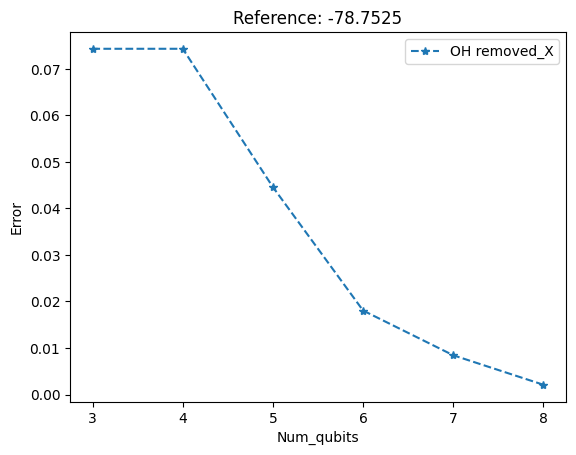

In [12]:
Q_list = []
result_list = []
generator = Q.find_ZZ_sym(hamiltonian)
Tapered_ham = Q.taper(hamiltonian,generator,electron)
ref = ground_energy(Tapered_ham)

for i in range(6):
    try:
        taper_ham_temp, hatree1 = Q.taper_X_remove(hamiltonian,i+1,electron)
        result_list.append(abs(ref-ground_energy(taper_ham_temp)))
        Q_list.append(int(taper_ham_temp.num_qubits))
    except:
        break

plt.xlabel('Num_qubits')
plt.ylabel('Error')
plt.xticks(Q_list)
plt.plot(Q_list,result_list,'--',label=f"OH removed_X",marker='*')
plt.title(f'Reference: {ref:.4f}')
plt.legend()
plt.show()

### Results From Other Molecules

![image.png](images/taper_OHH.png) ![image-2.png](images/taper_NeH.png) ![image-3.png](images/taper_HF.png) ![image-4.png](images/taper_CHH.png)

### Grouping The Hamiltonian
we grouped hamiltonian using graph method.  
We made represented Pauli terms in hamiltonian as nodes in graph and single commutation between Pauli terms as edges.  
And found each closed part, which is group of hamiltoian.  
  
As the finding the optimal number of group is NP hard problem, we used complement(G), which can find the groups easily but does not guarantee the best grouping.

We could group the hamiltonian into `19 parts`

In [13]:
g_ham = Q.group_ham(taper_ham)

print("Observation number before : ",len(taper_ham))
print("Observation number grouping : ",len(g_ham))

Observation number before :  101
Observation number grouping :  19


### Running Ideal Simulation
We conducted the ideal quantum simulation using qiskit aer simulator sampler primitive.  
  
For ansatz, we made our own `number-preserving ansatz` which consists of some X gates for initial state and `XXplusYY` gates.  
Our custom ansatz is motivated from problem hamiltonian.  
We chose pauli string representing exchange of state (or excitation and relaxation of electron)  
and those having a coefficient bigger than threshold are included in our ansatz

In [14]:
seeds = 170
algorithm_globals.random_seed = seeds
seed_transpiler = seeds
iterations = 125
shot = 30000
simulator = Aer.get_backend('aer_simulator_statevector')

In [15]:
sampler = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU'
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler
    }
)
itter = [0]
counts = []
values = []
paras = []
def cb(exp_value, para):
    print("itteration count : ",itter[0])
    counts.append(itter[0])
    values.append(exp_value)
    print("E_val : " ,values[-1])
    paras.append(para)
    itter[0] += 1     
    

In [16]:
ansatz = Q.EF_ansatz(taper_ham,hatree,Fraction=1/10,reverse=True)
ansatz.draw()

┌───┐┌───────────────┐
q_0: ┤ X ├┤1              ├
     ├───┤│               │
q_1: ┤ X ├┤               ├
     ├───┤│  Givens(T[0]) │
q_2: ┤ X ├┤               ├
     └───┘│               │
q_3: ─────┤0              ├
     ┌───┐├───────────────┤
q_4: ┤ X ├┤0              ├
     └───┘│  Givens(T[1]) │
q_5: ─────┤1              ├
          └───────────────┘

In [17]:
from scipy.optimize import minimize
Init_pt = [0]*ansatz.num_parameters
Optimum = minimize(Q.expectation_value_circ,Init_pt,args=(ansatz,g_ham,sampler,cb),method='COBYLA',options={"maxiter":5000,"rhobeg":np.pi,'eps':0.000005})

itteration count :  0
E_val :  -78.67658871708596
itteration count :  1
E_val :  -78.05417184033692
itteration count :  2
E_val :  -78.0798924636897
itteration count :  3
E_val :  -77.41272536593065
itteration count :  4
E_val :  -78.05909218957058
itteration count :  5
E_val :  -78.65359319278438
itteration count :  6
E_val :  -78.67764379177015
itteration count :  7
E_val :  -78.65645427457711
itteration count :  8
E_val :  -78.65693245707817
itteration count :  9
E_val :  -78.67545978984062
itteration count :  10
E_val :  -78.66622839024619
itteration count :  11
E_val :  -78.70269149879107
itteration count :  12
E_val :  -78.71360376566692
itteration count :  13
E_val :  -78.7106042947667
itteration count :  14
E_val :  -78.69696159078468
itteration count :  15
E_val :  -78.71294348376074
itteration count :  16
E_val :  -78.70937008474101
itteration count :  17
E_val :  -78.7133707183811
itteration count :  18
E_val :  -78.71261652771625
itteration count :  19
E_val :  -78.71254298

In [18]:
print("minimum value : ",np.array(values).min())
print("Error tapered optimal value: ",abs(ground_energy(taper_ham)-np.array(values).min()))
print("Optimum point : ", paras[np.array(values).argmin()])

minimum value :  -78.71361088612083
Error tapered optimal value:  0.020860821466172297
Optimum point :  [0.10147891 0.38121962]


### Running Noisy Simulation & Readout Error Mitigation
One of the mitigation techniques widely used in superconducting qubit system is readout error mitigation.  
There are many types of readout error mitigation techniques but we used simple method of applying inverse of readout matrix.  
Readout Error matrix was extracted from noise model.

Also, we changed the hamiltonian's Z paulis into -Z.  
By this simple trick, we can change all 1 states in initial and final quantum states into 0 states.  
Because qubits in 1 state tends to drop into 0 state, more 0 states in quantum circuit means less errors.  
As we can easily calculate Fock state of hamiltonian and it need more 1 state than 0 state, this trick can be helpful.

In [19]:
with open(path_noise_model['montreal'], 'rb') as file:
    noise_model_dict = pickle.load(file)
noise_model = noise.NoiseModel.from_dict(noise_model_dict)

In [20]:
if hatree.count(1)>hatree.count(0):
    taper_ham_noisy = Q.Z_exchange(taper_ham)
    hatree_noisy = []
    for value in hatree:
        if value == 0:
            hatree_noisy.append(1)
        else:
            hatree_noisy.append(0)
else:
    taper_ham_noisy = taper_ham
    hatree_noisy = hatree

In [21]:
ansatz_noisy = Q.EF_ansatz(taper_ham_noisy,hatree_noisy,Fraction=1/10,reverse=True)
g_ham_noisy = Q.group_ham(taper_ham_noisy)
ansatz_noisy.draw()

┌───────────────┐
q_0: ─────┤1              ├
          │               │
q_1: ─────┤               ├
          │  Givens(T[0]) │
q_2: ─────┤               ├
     ┌───┐│               │
q_3: ┤ X ├┤0              ├
     └───┘├───────────────┤
q_4: ─────┤0              ├
     ┌───┐│  Givens(T[1]) │
q_5: ┤ X ├┤1              ├
     └───┘└───────────────┘

In [22]:
## find the best point in fake backend
ansatz_noisy = transpile(ansatz_noisy,basis_gates=['x', 'sx', 'id', 'cx','rz'],optimization_level=3)
ansatz_hardware = transpile(ansatz_noisy,backend=FakeMontreal(),optimization_level=3)
qubit_location = [1,2,3,4,5,6]
for i in range(27):
    if ansatz_hardware._layout.initial_layout[i].register.name == 'q':
        qubit_location[ansatz_hardware._layout.initial_layout[i].index] = i
    
print("Qubit use in real backend : ",qubit_location)

Qubit use in real backend :  [26, 0, 1, 25, 13, 14]


In [23]:
itter = [0]
counts = []
values = []
paras = []
sampler_noisy = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': noise_model,
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler,
        'optimization_level':0,
    }
)

In [24]:
itter = [0]
counts = []
values = []
paras = []
Init_pt = [0 , 0]
Optimum = minimize(
    Q.expectation_value_circ_err_mit,
    Init_pt,
    args=(ansatz_noisy,g_ham_noisy,sampler_noisy,qubit_location,noise_model,True,True,cb),
    method='COBYLA',
    options={"maxiter":300,"rhobeg":np.pi,'eps':0.0001}
)

itteration count :  0
E_val :  -77.97983205512668
itteration count :  1
E_val :  -77.1842351720578
itteration count :  2
E_val :  -77.386504711695
itteration count :  3
E_val :  -76.51547988568365
itteration count :  4
E_val :  -77.54928753626776
itteration count :  5
E_val :  -77.7007385039841
itteration count :  6
E_val :  -77.71115502249876
itteration count :  7
E_val :  -77.84139791799171
itteration count :  8
E_val :  -77.94052126109207
itteration count :  9
E_val :  -77.81869732112632
itteration count :  10
E_val :  -77.96857434886765
itteration count :  11
E_val :  -77.97248360743143
itteration count :  12
E_val :  -77.972265629608
itteration count :  13
E_val :  -77.98302497529946
itteration count :  14
E_val :  -77.98676405680628
itteration count :  15
E_val :  -77.98927895073905
itteration count :  16
E_val :  -77.9864101107779
itteration count :  17
E_val :  -77.99303034423248
itteration count :  18
E_val :  -77.99685033422216
itteration count :  19
E_val :  -77.997253297491

### Reference Error Mitigation
Lolur, Phalgun, et al. "Reference-State Error Mitigation: A Strategy for High Accuracy Quantum Computation of Chemistry." Journal of Chemical Theory and Computation 19.3 (2023): 783-789.  
<https://arxiv.org/abs/2203.14756>  

Reference Error Mitigation technique utilizes ease of Fock state energy calculation.  
By comparing Fock state's ideal and noisy energy value and using the offset as a reference of noise, we can mitigate our resulting state's energy.



In [25]:
Ref_value = Q.hatree_value(hatree,taper_ham) ## calculate classcially (Cost O(N^2))
Correct_factor = Ref_value - values[0]
Mitigatied_value =  np.array(values).min() + Correct_factor 

In [26]:
print("NISQ value with mitigation : ",Mitigatied_value[0].real)

NISQ value with mitigation :  -78.73499081063821


### Calculating The Accuracy (Most Important Metric)
According to scoring criteria, we calculated the ground state energy estimation accuracy.

In [28]:
ref_value = -74.38714627
result = Mitigatied_value[0] + 4.36537496654537
accuracy = (1 - abs((ref_value - result) / ref_value)) * 100
print(f"Estimation accuracy : {accuracy}%")

Estimation accuracy : 99.97643352812119%


### Obtaining The Duration Of Quantum Circuit

In [29]:
from qiskit.providers.fake_provider import *
backend = FakeMontreal()

with pulse.build(backend) as my_program1:
  pulse.call(ansatz_noisy)

my_program1.duration

5056

### QASM Result
As we utilized Reference State Error Mitigation technique, energy value from different backend can be largely different from optimal value.

Fakecairo

In [34]:
with open(path_noise_model['cairo'], 'rb') as file:
    noise_model = pickle.load(file)
noise_model1 = noise.NoiseModel()
noise_modelreal = noise_model1.from_dict(noise_model)
sampler_noisy = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': noise_modelreal,
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler,
        'optimization_level':0,
    }
)

In [36]:
qc = QuantumCircuit.from_qasm_file(os.path.join(dir_qasm, 'cairo_QASM'))
ansatz_hardware = transpile(ansatz_noisy,backend=FakeCairo(),optimization_level=3)
### our optimized location
qubit_location = [24, 0, 1, 23, 12, 10]
res = Q.expectation_value_circ_err_mit([0,0],qc,g_ham_noisy,sampler_noisy,qubit_location, noise_modelreal, True, True)   

## get result before REM
print("before mitgate :",res )

## REM
Ref_value = Q.hatree_value(hatree,taper_ham) ## calculate classcially (Cost O(N^2))
Correct_factor = Ref_value - Q.expectation_value_circ_err_mit([0,0],ansatz_noisy,g_ham_noisy,sampler_noisy,qubit_location, noise_modelreal, True, True)
Mitigatied_value =  res + Correct_factor 
print("after mitigate : ",Mitigatied_value[0].real)

before mitgate : -78.57631936045884
after mitigate :  -78.70824924686569


Fakemontreal

In [30]:
with open(path_noise_model['montreal'], 'rb') as file:
    noise_model = pickle.load(file)
noise_model1 = noise.NoiseModel()
noise_modelreal = noise_model1.from_dict(noise_model)
sampler_noisy = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': noise_modelreal,
    },
    run_options = {
        'shots': shot,
        'seed': seeds
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler,
        'optimization_level':0,
    }
)

In [31]:
qc = QuantumCircuit.from_qasm_file(os.path.join(dir_qasm, 'montreal_QASM'))
ansatz_hardware = transpile(ansatz_noisy,backend=FakeMontreal(),optimization_level=3)
### our optimized location
qubit_location = [24, 0, 1, 23, 12, 10]
res = Q.expectation_value_circ_err_mit([0,0],qc,g_ham_noisy,sampler_noisy,qubit_location, noise_modelreal, True, True)
## get result before REM
print("before mitgate :",res)

## REM
Ref_value = Q.hatree_value(hatree,taper_ham) ## calculate classcially (Cost O(N^2))
Correct_factor = Ref_value - Q.expectation_value_circ_err_mit([0,0],ansatz_noisy,g_ham_noisy,sampler_noisy,qubit_location, noise_modelreal, True, True)
Mitigatied_value =  res + Correct_factor 

print("after mitigate : ",Mitigatied_value[0].real)

before mitgate : -78.72197097612847
after mitigate :  -78.72185556162047


Fakekolkata

In [32]:
with open(path_noise_model['kolkata'], 'rb') as file:
    noise_model = pickle.load(file)
noise_model1 = noise.NoiseModel()
noise_modelreal = noise_model1.from_dict(noise_model)
sampler_noisy = Sampler(
    backend_options = {
        'method': 'statevector',
        'device': 'CPU',
        'noise_model': noise_modelreal,
    },
    run_options = {
        'shots': shot,
        'seed': seeds,
    },
    transpile_options = {
        'seed_transpiler':seed_transpiler,
        'optimization_level':0,
    }
)

In [33]:
qc = QuantumCircuit.from_qasm_file(os.path.join(dir_qasm, 'kolkata_QASM'))
ansatz_hardware = transpile(ansatz_noisy,backend=FakeKolkata(),optimization_level=3)
### our optimized location
qubit_location = [16, 0, 1, 14, 25, 24]
    
res = Q.expectation_value_circ_err_mit([0,0],qc,g_ham_noisy,sampler_noisy,qubit_location, noise_modelreal, True, True)
## get result before REM
print("before mitgate :",res)

## REM
Ref_value = Q.hatree_value(hatree,taper_ham) ## calculate classcially (Cost O(N^2))
Correct_factor = Ref_value - Q.expectation_value_circ_err_mit([0,0],ansatz_noisy,g_ham_noisy,sampler_noisy,qubit_location, noise_modelreal, True, True)
Mitigatied_value =  res + Correct_factor 

print("after mitigate : ",Mitigatied_value[0].real)

before mitgate : -78.26180844108873
after mitigate :  -78.70933876132801
